# Estimate the Specs of a Lattice

In [15]:
import numpy as np
from numpy import pi
from pyquil.api import get_qc
from pyquil import Program
from pyquil.gates import *

import matplotlib.pyplot as plt
%matplotlib inline



Specify lattice name and show any stored specs

In [16]:
# quantum_processor_id = 'Aspen-1-5Q-B'
quantum_processor_id = '9q-square-noisy-qvm'

Create qc object, get qubits, and display the topology

**BE SURE TO SET as_qvm TRUE or FALSE as desired!!!**

[0, 1, 2, 3, 4, 5, 6, 7, 8]


/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


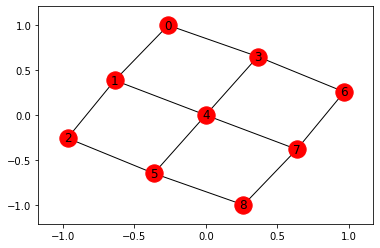

In [17]:
import networkx as nx

qc = get_qc(quantum_processor_id, as_qvm=True, noisy=True)
qubits = qc.qubits()
print(qubits)
graph = qc.qubit_topology()
nx.draw_networkx(graph, with_labels=True)

## Active Reset Error
These estimates will be affected by readout error as well, so it may be best to try to correct for that. 

In [12]:
from forest.benchmarking.readout import estimate_joint_reset_confusion
single_qubit_reset_cms = estimate_joint_reset_confusion(qc, qubits, num_trials = 10, joint_group_size = 1,
                                   use_active_reset = True, show_progress_bar=True)


100%|██████████| 18/18 [01:00<00:00,  3.26s/it]


Confusion matrix, Avg Fidelity

In [13]:
print('Single qubit confusion matrices: \n', single_qubit_reset_cms)
print('Reset fidelity per qubit: ', [np.round(np.sum(cm, axis=0)[0]/2, 3) for cm in single_qubit_reset_cms.values()])


Single qubit confusion matrices: 
 {(0,): array([[1., 0.],
       [1., 0.]]), (1,): array([[0.8, 0.2],
       [1. , 0. ]]), (2,): array([[1., 0.],
       [1., 0.]]), (3,): array([[1., 0.],
       [1., 0.]]), (4,): array([[1., 0.],
       [1., 0.]]), (5,): array([[1., 0.],
       [1., 0.]]), (6,): array([[1. , 0. ],
       [0.9, 0.1]]), (7,): array([[1., 0.],
       [1., 0.]]), (8,): array([[0.9, 0.1],
       [1. , 0. ]])}
Reset fidelity per qubit:  [1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 0.95]


## Readout Errors

In [15]:
from forest.benchmarking.readout import estimate_joint_confusion_in_set, marginalize_confusion_matrix
single_qubit_cms = estimate_joint_confusion_in_set(qc, qubits, num_shots=5000, joint_group_size=1,
                                    use_param_program=True, use_active_reset=False, show_progress_bar=True)


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


Confusion matrix, Avg Fidelity, Asymmetry

In [17]:
print('Single qubit confusion matrices: \n', single_qubit_cms)
print('Avg. fidelity per qubit: ', [np.round(np.trace(cm)/2, 3) for cm in single_qubit_cms.values()])
from pyquil.simulation.matrices import Z as Z_mat
print('Asymmetry magnitude: ', [np.round(np.trace(Z_mat @ cm)/2, 3) for cm in single_qubit_cms.values()])

Single qubit confusion matrices: 
 {(0,): array([[0.9766, 0.0234],
       [0.0944, 0.9056]]), (1,): array([[0.9764, 0.0236],
       [0.0886, 0.9114]]), (2,): array([[0.9734, 0.0266],
       [0.0856, 0.9144]]), (3,): array([[0.9738, 0.0262],
       [0.085 , 0.915 ]]), (4,): array([[0.9736, 0.0264],
       [0.0948, 0.9052]]), (5,): array([[0.9702, 0.0298],
       [0.097 , 0.903 ]]), (6,): array([[0.979 , 0.021 ],
       [0.0962, 0.9038]]), (7,): array([[0.9736, 0.0264],
       [0.0922, 0.9078]]), (8,): array([[0.9734, 0.0266],
       [0.0942, 0.9058]])}
Avg. fidelity per qubit:  [0.941, 0.944, 0.944, 0.944, 0.939, 0.937, 0.941, 0.941, 0.94]
Asymmetry magnitude:  [0.035, 0.032, 0.029, 0.029, 0.034, 0.034, 0.038, 0.033, 0.034]


Simultaneous Confusion Matrix (pairwise; can try len(qubits) but may be too slow)

In [18]:
pairwise_cms = estimate_joint_confusion_in_set(qc, qubits, num_shots=1000, joint_group_size=2,
                                    use_param_program=True, use_active_reset=False, show_progress_bar=True)

100%|██████████| 144/144 [00:37<00:00,  3.89it/s]


 Look for Significant Correlated Error

In [19]:
marginal_absolute_tolerance = .02 # determines acceptable level of correlation

for qubit_pair, pair_cm in pairwise_cms.items():
    marginal_one_qs = [(qubit, marginalize_confusion_matrix(pair_cm, qubit_pair, [qubit])) for qubit in qubit_pair]
    for qubit, marginal_cm in marginal_one_qs:
        if not np.allclose(single_qubit_cms[(qubit,)], marginal_cm, atol=marginal_absolute_tolerance):
            print("Q" + str(qubit) + " readout is different when measuring pair", qubit_pair)
            
joint_absolute_tolerance = .03
for qubit_pair, pair_cm in pairwise_cms.items():
    joint_single_q_cm = np.kron(single_qubit_cms[(qubit_pair[0],)], single_qubit_cms[(qubit_pair[1],)])
    if not np.allclose(joint_single_q_cm, pair_cm, atol=joint_absolute_tolerance):
        print(qubit_pair, "exhibits correlated readout error")


Q0 readout is different when measuring pair (0, 3)
(1, 4) exhibits correlated readout error


## T1/T2

Neither estimation of T1 or T2 will work on a QVM

### T1

In [7]:
from forest.benchmarking.qubit_spectroscopy import MICROSECOND, do_t1_or_t2
stop_time = 60 * MICROSECOND
num_points = 15
times = np.linspace(0, stop_time, num_points)
t1s_by_qubit = do_t1_or_t2(qc, qubits, times, kind='t1', show_progress_bar=True)[0]
print("T1s in microseconds: \n", t1s_by_qubit)

100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


T1s in microseconds: 
 {0: 2783.881102933884, 1: 4641545.421193193, 2: 2910.2536036540473, 3: 5205.9949953174355, 4: 19773760.773035187, 5: 17255.97711792395, 6: 2375.3523414087367, 7: 9808.665911517175, 8: 5991.777676783236}


### $T_2^*$ Ramsey

In [9]:
t2s_by_qubit = do_t1_or_t2(qc, qubits, times, kind='t2_star', show_progress_bar=True)[0]
print("T2s in microseconds: \n", t2s_by_qubit)

100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


T2s in microseconds: 
 {0: 1524852.770913139, 1: 289.5321651003401, 2: 29876448.680671595, 3: 10393069.285889667, 4: 101.43661546142518, 5: 28118719.891289398, 6: 18582565.55365791, 7: 3303.775358787086, 8: 0.13678009147608122}


## Single Qubit RB Gate Error

In [20]:
from pyquil.api import BenchmarkConnection
from forest.benchmarking.randomized_benchmarking import do_rb
bm = BenchmarkConnection()

Estimate 1q fidelity separately 

In [21]:
num_sequences_per_depth = 10
depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence
num_shots = 1000
rb_decays_by_qubit = {}
rb_results_by_qubit = {}
for qubit in qubits:
    qubit_groups = [(qubit,)]
    decays, _, results = do_rb(qc, bm, qubit_groups, depths, num_shots=num_shots,
                               show_progress_bar=True)
    rb_decays_by_qubit[qubit] = decays[qubit_groups[0]]
    rb_results_by_qubit[qubit] = results

print(rb_decays_by_qubit)

100%|██████████| 40/40 [00:15<00:00,  2.54it/s]

{0: 0.9999743562108797, 1: 0.9964969435485571, 2: 0.9988028235204742, 3: 0.9999589350281467, 4: 0.9981753716620283, 5: 0.9944043242435668, 6: 0.9990160707914773, 7: 0.994696725851607, 8: 0.9960693803589553}


Plot the results to see if there is a good fit. 
**SLOW**

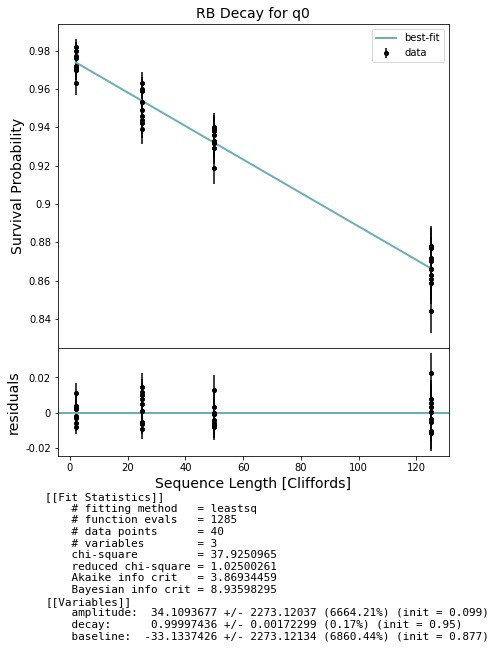

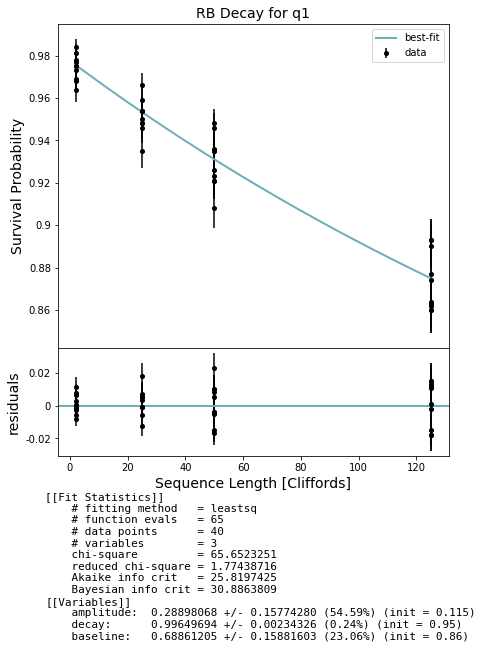

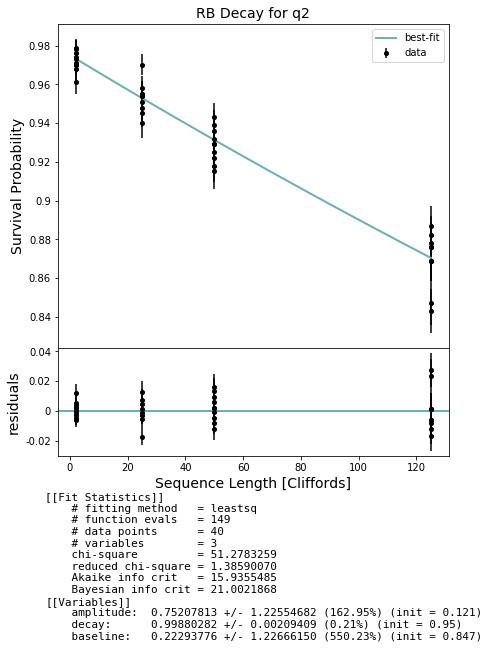

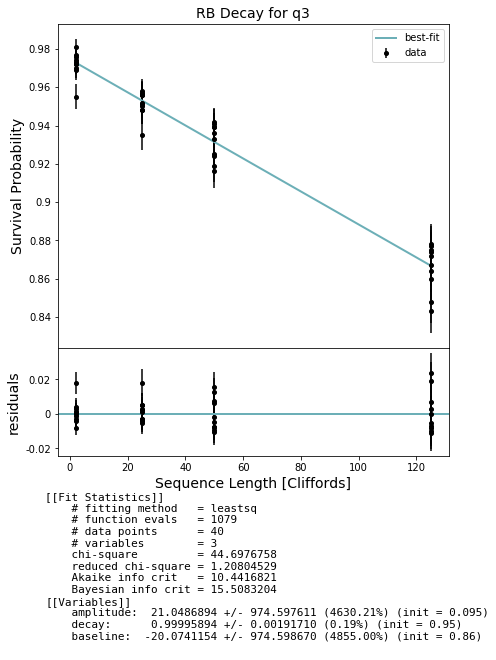

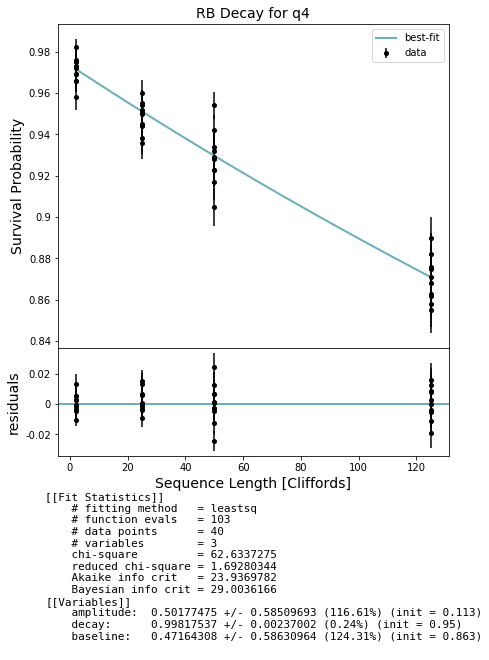

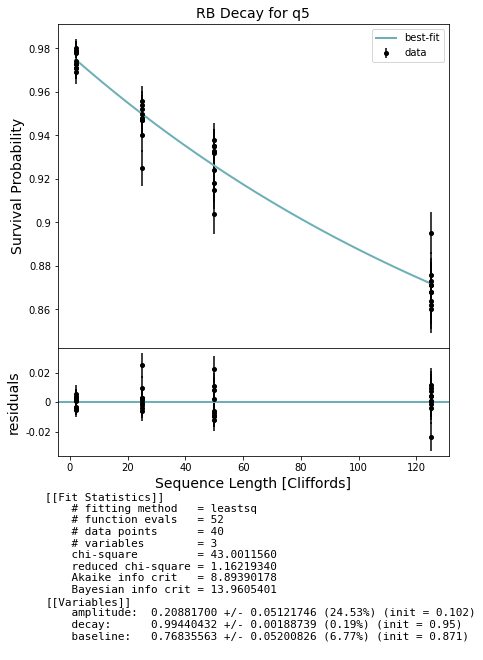

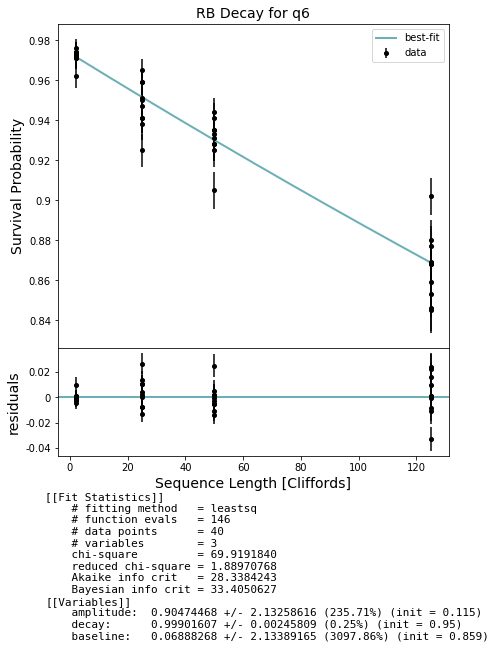

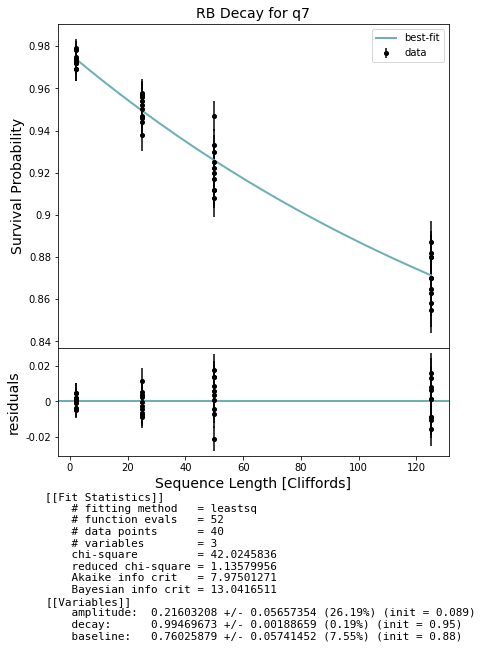

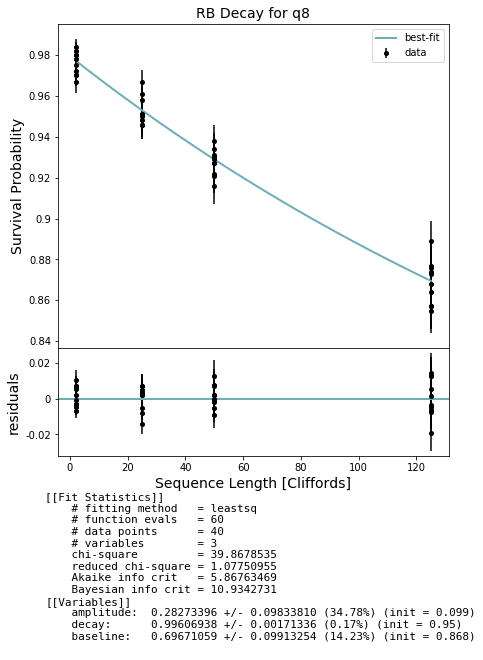

In [22]:
from forest.benchmarking.randomized_benchmarking import get_stats_by_qubit_group, fit_rb_results
from forest.benchmarking.plotting import plot_figure_for_fit

for qubit in qubits:
    qubit_groups = [(qubit,)]

    stats = get_stats_by_qubit_group(qubit_groups, rb_results_by_qubit[qubit])[qubit_groups[0]]

    # fit the exponential decay model
    fit_1q = fit_rb_results(depths, stats['expectation'], stats['std_err'])
    
    fig, ax = plot_figure_for_fit(fit_1q, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability", 
                                  title=f'RB Decay for q{qubit}')

Estimate simultaneous 1q fidelity
**SLOW**

In [23]:
# use the same parameters as above for comparison

# num_sequences_per_depth = 10
# depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence
# num_shots = 1000

qubit_groups = [(qubit,) for qubit in qubits]
simult_decays, _, simult_results = do_rb(qc, bm, qubit_groups, depths, num_shots=num_shots,
                               show_progress_bar=True)

print(simult_decays)

100%|██████████| 40/40 [16:44<00:00, 25.11s/it]


{(0,): 0.9980096129535115, (1,): 0.9999421676815119, (2,): 0.9959071596671846, (3,): 0.995686471173284, (4,): 0.9999969414797557, (5,): 0.999992956854472, (6,): 0.9960924294933665, (7,): 0.9974094704997846, (8,): 0.9954053735043443}


In [25]:
for qubit, decay in rb_decays_by_qubit.items():
    simult_decay = simult_decays[(qubit,)]
    if not np.allclose(simult_decay, decay, atol = .05):
        print("qubit " + str(qubit) + " may be suffering from significant 1q cross-talk.")

## DFE CZ Fidelity 

(**SLOW** on qvm)

In [4]:
print('Obtaining CZ fidelity on every edge in: ', graph.edges())

Obtaining CZ fidelity on every edge in:  [(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8)]


In [5]:
from forest.benchmarking.direct_fidelity_estimation import do_dfe

from pyquil.api import BenchmarkConnection
bm = BenchmarkConnection()

cz_fidelities = {}
for edge in graph.edges():
    p = Program(CZ(edge[0], edge[1]))
    (fidelity, std_err), _, _ = do_dfe(qc, bm, p, list(edge), kind='process', show_progress_bar=True)
    print(edge, " : ", fidelity, "+/-", std_err)
    cz_fidelities[tuple(edge)] = fidelity

  0%|          | 0/152 [00:00<?, ?it/s]

(0, 3)  :  0.9923874573877411 +/- 0.0019115865212059342


  0%|          | 0/152 [00:00<?, ?it/s]

(0, 1)  :  0.992886387726406 +/- 0.0019208487996977257


  0%|          | 0/152 [00:00<?, ?it/s]

(1, 4)  :  0.9950827422787366 +/- 0.001966855920170796


  0%|          | 0/152 [00:00<?, ?it/s]

(1, 2)  :  0.9887705026547662 +/- 0.001925004453638678


  0%|          | 0/152 [00:00<?, ?it/s]

(2, 5)  :  0.9942740978403716 +/- 0.0019460547918099262


  0%|          | 0/152 [00:00<?, ?it/s]

(3, 6)  :  0.9908451865259076 +/- 0.0019082010857206318


  0%|          | 0/152 [00:00<?, ?it/s]

(3, 4)  :  0.9892872513479407 +/- 0.0019279603667508773


  0%|          | 0/152 [00:00<?, ?it/s]

(4, 7)  :  0.9882708344386948 +/- 0.001904071950387435


  0%|          | 0/152 [00:00<?, ?it/s]

(4, 5)  :  0.9909897937711392 +/- 0.0019295427116144698


  0%|          | 0/152 [00:00<?, ?it/s]

(5, 8)  :  0.9923139468202515 +/- 0.001922802694939426


  0%|          | 0/152 [00:00<?, ?it/s]

(6, 7)  :  0.9925828452583773 +/- 0.0019388240059197773


100%|██████████| 152/152 [00:26<00:00,  5.77it/s]


(7, 8)  :  0.9942185850510858 +/- 0.00194923664765627


## Coherent impact of CZ Cross Talk

This estimates the effective RZ phase on each qubit due to some CZ gate. 

In [18]:
from forest.benchmarking.robust_phase_estimation import do_rpe
edge = list(graph.edges())[0]
rotation = CZ(*edge)
measure_qubit = 0
qubit_groups = [(qubit,) for qubit in qubits]
changes_of_basis = [I(qubit) for qubit in qubits]

effective_phases, _, _= do_rpe(qc, rotation, changes_of_basis, qubit_groups, num_depths=7, 
                          active_reset=True, mitigate_readout_errors=False,
                          show_progress_bar=True)
print(effective_phases)

100%|██████████| 7/7 [00:22<00:00,  3.19s/it]

{(0,): 0.0023765747202830964, (1,): 0.0014647115866288848, (2,): 0.0022266515196207315, (3,): 6.2828133536454445, (4,): 0.0008746241582207187, (5,): 0.0019510926181242408, (6,): 0.0018102831235347894, (7,): 6.282727801986684, (8,): 0.0004040047712384337}


## All qubits RX calibration
This is done in parallel to save time.

In [19]:
from forest.benchmarking.robust_phase_estimation import do_rpe
angles = [-pi, -pi/2, pi/2, pi]

qubit_groups = [(qubit,) for qubit in qubits]
changes_of_basis = [H(qubit) for qubit in qubits]

for angle in angles:
    rotation = Program([RX(angle, qubit) for qubit in qubits])
    phases, expts, ress = do_rpe(qc, rotation, changes_of_basis, qubit_groups, num_depths=6, 
                          active_reset=True, mitigate_readout_errors=False,
                          show_progress_bar=True)
    print('expected phase: ', angle % (2*pi))
    print(phases)


  0%|          | 0/6 [00:00<?, ?it/s]

expected phase:  3.141592653589793
{(0,): 3.144227238981237, (1,): 3.142609736171609, (2,): 3.1453021953755176, (3,): 3.1442727150642886, (4,): 3.145790198650823, (5,): 3.1436821679667757, (6,): 3.141866769366182, (7,): 3.144500895112431, (8,): 3.1436546338560696}


  0%|          | 0/6 [00:00<?, ?it/s]

expected phase:  4.71238898038469
{(0,): 4.71238898038469, (1,): 4.712817035802592, (2,): 4.716559642080101, (3,): 4.714861779856415, (4,): 4.715957108679767, (5,): 4.716167191769149, (6,): 4.715877776410458, (7,): 4.716362854632278, (8,): 4.713237188314599}


  0%|          | 0/6 [00:00<?, ?it/s]

expected phase:  1.5707963267948966
{(0,): 1.5758913873873468, (1,): 1.5754998211164968, (2,): 1.5751689727503377, (3,): 1.5751049401874313, (4,): 1.573163440897174, (5,): 1.5753925254007841, (6,): 1.5696706877502344, (7,): 1.5743644550899736, (8,): 1.5710791245047022}


100%|██████████| 6/6 [00:43<00:00,  7.31s/it]

expected phase:  3.141592653589793
{(0,): 3.143146800872157, (1,): 3.1458857173654557, (2,): 3.1421531316014235, (3,): 3.142564562322355, (4,): 3.1434625385686643, (5,): 3.142847558965439, (6,): 3.1399126595729876, (7,): 3.1431754002235466, (8,): 3.1433962040150734}
